In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import open3d as o3d
from datetime import datetime

from utils import *
from bpy_utils import ManusData, get_fbx_creation_time

import sys
manopth_dir = 'C:/Users/lucas/Desktop/UPC/MIT/manopth/'
sys.path.insert(1, manopth_dir)

from manus.utils import Pressure

In [3]:
recording_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/intrinsics_extrinsics/data/20210722/round_2_fixed_wooden_cube/"
recording_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/intrinsics_extrinsics/data/20210722/round_3_fixed_bottle_pose_1/"
recording_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/intrinsics_extrinsics/data/20210727_woIMU/r3/"

for name in os.listdir(recording_dir):
    name_pth = os.path.join(recording_dir, name)
    
    if os.path.isdir(name_pth):
        print("recording:", name)
        cameras_dir = name_pth
        
    elif ".hdf5" in name:
        print("pressure_file:", name)
        perssure_pth = name_pth
        
    elif ".fbx" in name:
        print("manus_file:", name)
        manus_pth = name_pth
        
#cameras_dir = os.path.join(recording_dir, "20210722_152500")
#perssure_pth = os.path.join(recording_dir, ".hdf5")
#manus_pth = os.path.join(recording_dir, ".fbx")

pressure_file: 07272021_3.hdf5
recording: 20210727_173327
manus_file: recording_2021-07-27_16-34-36.fbx


# Load data

### Camera data

In [4]:
cameras = ["020122061233", "821312060044", "020122061651", "821312062243"]

intrinsics = Intrinsics(cameras_dir, use_txt=False)
extrinsics = Extrinsics(cameras_dir)
rgbds = RGBD(cameras_dir)
stitched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)
apriltags = AprilTags(cameras_dir, intrinsics, extrinsics, cameras=cameras)
stitched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)

### Pressure data

In [5]:
pressure = Pressure(perssure_pth, lim_low=3, lim_high=50)

### Manus data

Takes around two minutes to load the manus data and compute the MANO joints and verts

In [6]:
%%capture

manus = ManusData(manus_pth, manopth_dir)

# Synchronize

#### Get timestamps

In [7]:
# Camera timestamps
ts_camera = get_camera_timestamps(cameras_dir)

# Pressure timestamps
ts_pressure = pressure.ts_touch

# MANUS timestamp
#pyfbx_i42_pth = "C:/Users/lucas/Desktop/UPC/MIT/pyfbx_i42-master/"
#ts_end = get_fbx_creation_time(manus_pth, pyfbx_i42_pth)
#ts_start = ts_end - len(manus) / 24
ts_manus = manus.get_ts(fps=30)

In [8]:
datetime.fromtimestamp(ts_pressure[-1]) - datetime.fromtimestamp(ts_pressure[0])

datetime.timedelta(seconds=68, microseconds=91845)

#### Find pressure camera offset


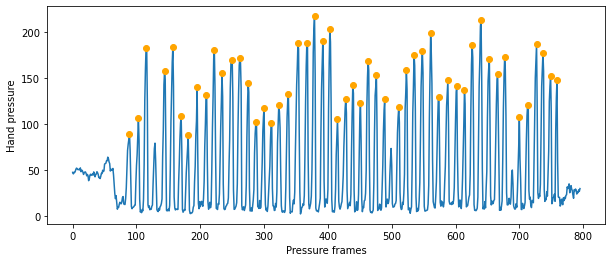

In [9]:
pressure.plot_peaks(height=80)

In [10]:
# Index of first pressure peak 
idx_first_p = pressure.get_peaks(height=80)[0]
# Timestamp of first pressure peak
ts_first_p = pressure.ts_touch[idx_first_p]

# Frame of first pressure in camera
frame_first_c = 108
# Timestamp of first pressure in camera
ts_first_c = ts_camera[frame_first_c]

# Offset between pressure and camera
pc_offset = ts_first_p - ts_first_c

#### Find manus camera offset


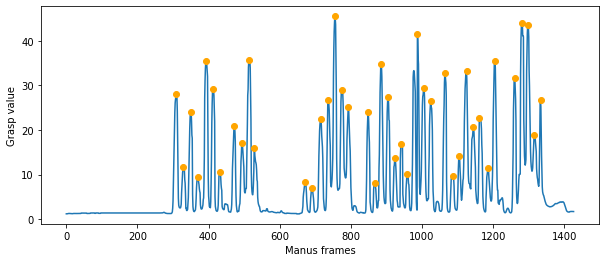

In [11]:
manus.plot_grasps(height=5)

In [12]:
manus.get_grasps(height=5)

array([ 309,  329,  350,  369,  393,  413,  431,  472,  494,  514,  529,
        672,  691,  715,  737,  755,  776,  793,  848,  867,  885,  905,
        924,  941,  959,  987, 1005, 1024, 1065, 1087, 1104, 1125, 1144,
       1161, 1186, 1205, 1260, 1280, 1298, 1316, 1333], dtype=int64)

In [13]:
# Index of first manus grasp peak 
idx_first_m = manus.get_grasps(height=5)[0]
# Timestamp of first manus grasp peak
ts_first_m = ts_manus[idx_first_m]

# Frame of first grasp in camera
frame_first_c = 108
# Timestamp of first pressure in camera
ts_first_c = ts_camera[frame_first_c]

# Offset between pressure and camera
mc_offset = ts_first_m - ts_first_c

In [14]:
datetime.fromtimestamp(ts_first_m) - datetime.fromtimestamp(ts_first_c) 

datetime.timedelta(days=1, seconds=77511, microseconds=390067)

#### Synchronize pressure + camera + manus

In [15]:
synchronize = Synchronizer(ts_p=ts_pressure, ts_c=ts_camera, ts_m=ts_manus, pc_offset=pc_offset, mc_offset=mc_offset)

# Merge camera + pressure + manus

#### Estimate object position

In [44]:
%%capture

pcd = stitched_pcd["000000"]

obj_name = "005_tomato_soup_can"
obj_name = "003_cracker_box"
obj_name = "006_mustard_bottle"
obj_name = "036_wood_block"

obj_pth = f"C:/Users/lucas/Desktop/UPC/MIT/tactile2object/estimate_object_pose/ycb_converted/{obj_name}.ply"

# Useful when running the cell multiple times
try:
    obj_mesh_t # obj_mesh_t exist in the current namespace
except NameError:
    transformation, obj_mesh_t = find_object_transformation(pcd, obj_pth)

In [17]:
#o3d.visualization.draw_geometries([pcd, obj_mesh_t])

#### Plot mesh_hand + object + AprilTag

In [45]:
frame_c = 652
frame_m = synchronize.camera_to_manus(frame_c)
frame_c = str(frame_c).zfill(6)

# pcd = stitched_pcd[frame_c]
corners_w = apriltags.corners_w(idx=frame_c)

rectangle = get_rectangle_from_corners(corners_w)
mesh_hand = manus.from_corners(frame_m, corners_w)

o3d.visualization.draw_geometries([mesh_hand, obj_mesh_t, rectangle, stitched_pcd[frame_c]])

# Save tactile img

In [ ]:
tactile_dir = os.path.join(apriltags.cameras_dir, "imgs", "pressure_img")

if not os.path.exists(tactile_dir):
    os.makedirs(tactile_dir)

for frame_c in range(len(ts_camera)):
    frame_p = synchronize.camera_to_pressure(frame_c)
    
    fig = pressure.get_figure(frame_p, show=False)
    img_pth = os.path.join(tactile_dir, f"img_{frame_c}")
    fig.savefig(img_pth)
    
    break

# Save MANUS

#### Manus with object

In [34]:
out_dir = os.path.join(apriltags.cameras_dir, "imgs", "manus_img")

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

corners_w = apriltags.corners_w(idx='000075')

for frame_m in range(0, len(manus)):
    rectangle = get_rectangle_from_corners(corners_w)
    mesh_hand = manus.from_corners(frame_m, corners_w)
    
    img_pth = os.path.join(out_dir, f"img_{frame_m}.png")
    save_draw_geometries([obj_mesh_t, mesh_hand], img_pth)

#### Manus +  object + pcd

In [64]:
out_dir = os.path.join(apriltags.cameras_dir, "imgs", "manus_pcd_img")

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
for frame_c in range(0, len(ts_camera)):
    frame_m = synchronize.camera_to_manus(frame_c)
    
    frame_c = str(frame_c).zfill(6)
    pcd = stitched_pcd[frame_c]
    
    corners_w = apriltags.corners_w(idx=frame_c)
    
    if corners_w is None:
        vis = pcd

    else:
        rectangle = get_rectangle_from_corners(corners_w)
        mesh_hand = manus.from_corners(frame_m, corners_w)
        
        vis = [pcd, mesh_hand, rectangle]
        
    img_pth = os.path.join(out_dir, f"img_{frame_c}.png")
    save_draw_geometries(vis, img_pth)